<a href="https://colab.research.google.com/github/EiffL/Tutorials/blob/master/PhotozCNN/photoz_inference_tfdatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019-2021 Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");

# Photometric Redshift Estimation with TensorFlow - Part II: Dataset preparation with TensorFlow Datasets

Author: [@EiffL](https://github.com/EiffL) (Francois Lanusse)

### Overview

This second notebook in the series focuses on one of the most important steps in a Deep Learning project: setting up your dataset!

The most common issues that you will face in practice are the following:

- Typical datasets can be several hundreds of gigabytes in size, they will not fit in the RAM of your training node. **How do I handle large datasets for training my neural network?**

- To optimize the training time, you want to keep the GPU busy at all times. So, you don't want to lose anytime preprocessing data on CPU or loading from disk during training. **How do I maximize the speed at which I feed data to my GPU?**

- Your work will only be reproducible if other people can easily retrieve and setup your dataset to train their own network. **How do I automatize download and preprocessing tasks for my data so that anyone can setup my dataset on their own computers in one line of code?**

Thanksfully, you are not the only one to wonder about these questions, and in this tutorial we will discover how to use [TensorFlow Datasets](https://www.tensorflow.org/datasets), a library that solves all of these questions for you!


We will use that library to create an easily sharable and reusable dataset for the HSC data retrieved in the [previous notebook](https://github.com/EiffL/Tutorials/blob/master/PhotozCNN/photoz_inference_data_preparation.ipynb) in this series.


### Learning objectives

In this notebook, we will learn how to:
* Discover TFDS and learn some of its key utilities
* Learn how to create a TFDS dataset for your own data



### Imports

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## A first look at TensorFlow Datasets

Let's begin by trying out TFDS on one of the existing datasets.

TFDS comes pre-packaged with a ton of datasets, for various applications, contributed by the community. You can have a look at all the existing ones [here](https://www.tensorflow.org/datasets/catalog/overview#all_datasets).

We'll start by playing with the famous [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist).

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [19]:
# Loading the MNIST dataset
dset = tfds.load('mnist',     # This is the name of the dataset we want to load
                 split='train') # This defines which 'split' we want to use

And that's it! the library has automatically downloaded, prepared, and cached the MNIST data for you!


At this point, dset is an instance of the `tf.data.Dataset` class, which is the cannonical way to handle datasets in TensorFlow. It can be manipulated in a number of ways.

In [4]:
dset

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

We see that it contains both `image` and associated `label`.

#### **Extracting a few example from the dataset**

This is typically done inside a for loop in the following way:

In [7]:
for example in dset.take(1):
  print('This is a ', example['label'].numpy())

This is a  4


Here, `.take(1)` restricts the dataset to just one example. The for loop iterates through these examples.

This example should also contain an image:

In [10]:
example['image'].shape

TensorShape([28, 28, 1])

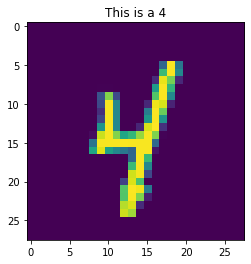

In [12]:
imshow(example['image'][:,:,0])
title('This is a %d'%example['label'].numpy());

#### **Creating an input pipeline for shuffling and batching**

This API allows you to apply transformations to your dataset, for typical operations like batching or shuffling.

Here is how a typical input pipeline for training a neural network would look like:

In [20]:
dset = dset.repeat()         # Repeat the dataset for ever
dset = dset.shuffle(1024)    # Apply shuffling with a buffer of size 1024 
dset = dset.batch(64)        # Batch the examples
dset = dset.prefetch(tf.data.AUTOTUNE)  # Prefecth examples for fast access

If I know take an example from dset:

In [21]:
for example in dset.take(1):
  image, label = example["image"], example["label"]

In [22]:
image.shape

TensorShape([64, 28, 28, 1])

I see that I indeed have a batch of images of size 64.

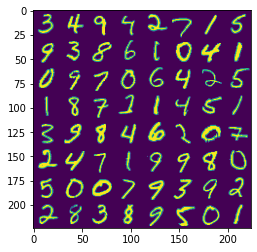

In [26]:
imshow(image.numpy().reshape([8,8,28,28]).transpose([0,2,1,3]).reshape([8*28,8*28]));

#### **Apply preprocessing functions**

In many circumstances, you want to apply some operations on the fly to your data during training. For instance to perform data augmentation. This is very easily done in the following way:

In [27]:
def my_mapping_fn(example):
  """Simple function doing augmentation by random flips"""
  im = example['image']
  im = tf.image.random_flip_up_down(im)
  im = tf.image.random_flip_left_right(im)
  return {'image': im, 'label': example['label']}

In [28]:
dset = dset.map(my_mapping_fn)

And that's it, my dataset is now transformed. Let's draw a bunch of examples:

In [29]:
for example in dset.take(1):
  image, label = example["image"], example["label"]

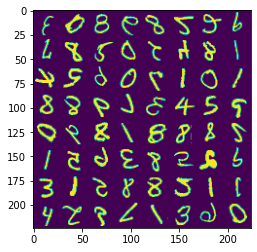

In [30]:
imshow(image.numpy().reshape([8,8,28,28]).transpose([0,2,1,3]).reshape([8*28,8*28]));

Coooool 🙃

Anyways, these few examples illustrate how easy it is to download some data, and prepare it for your neural network when you use TFDS.

Checkout the [documentation](https://www.tensorflow.org/datasets/overview) for more details and examples.


## Let's retrieve our HSC data

Now that we have seen how cool TFDS is, let's see if we can build our dataset to package our HSC data!

As in any problem, our first step is to do some quick inspection of the data.


In [31]:
# Download the dataset from Google cloud
!gsutil cp gs://ahw2019/hsc_photoz/data/catalog_small.fits catalog_small.fits
print('Catalog download complete')
!gsutil cp gs://ahw2019/hsc_photoz/data/cutouts_small.hdf cutouts_small.hdf
print('Cutouts download complete')

Copying gs://ahw2019/hsc_photoz/data/catalog_small.fits...
/ [1 files][500.6 KiB/500.6 KiB]                                                
Operation completed over 1 objects/500.6 KiB.                                    
Catalog download complete
Copying gs://ahw2019/hsc_photoz/data/cutouts_small.hdf...
/ [1 files][147.9 MiB/147.9 MiB]                                                
Operation completed over 1 objects/147.9 MiB.                                    
Cutouts download complete


This has downloaded a small subset of the raw HSC data we have extracted previously. 

Let's have a look at it:

In [32]:
import h5py
from astropy.table import Table

# Loading the data
catalog = Table.read('catalog_small.fits')       # This is an astropy table
cutouts = h5py.File('cutouts_small.hdf', 'r')    # This is a set of images

In [33]:
# Let's have a look at the catalog
catalog

object_id,ra,dec,tract,patch,a_g,a_r,a_i,a_z,a_y,g_extendedness_value,r_extendedness_value,i_extendedness_value,z_extendedness_value,y_extendedness_value,g_localbackground_flux,r_localbackground_flux,i_localbackground_flux,z_localbackground_flux,y_localbackground_flux,g_cmodel_flux,g_cmodel_fluxsigma,g_cmodel_exp_flux,g_cmodel_exp_fluxsigma,g_cmodel_dev_flux,g_cmodel_dev_fluxsigma,r_cmodel_flux,r_cmodel_fluxsigma,r_cmodel_exp_flux,r_cmodel_exp_fluxsigma,r_cmodel_dev_flux,r_cmodel_dev_fluxsigma,i_cmodel_flux,i_cmodel_fluxsigma,i_cmodel_exp_flux,i_cmodel_exp_fluxsigma,i_cmodel_dev_flux,i_cmodel_dev_fluxsigma,z_cmodel_flux,z_cmodel_fluxsigma,z_cmodel_exp_flux,z_cmodel_exp_fluxsigma,z_cmodel_dev_flux,z_cmodel_dev_fluxsigma,y_cmodel_flux,y_cmodel_fluxsigma,y_cmodel_exp_flux,y_cmodel_exp_fluxsigma,y_cmodel_dev_flux,y_cmodel_dev_fluxsigma,g_cmodel_mag,g_cmodel_magsigma,g_cmodel_exp_mag,g_cmodel_exp_magsigma,g_cmodel_dev_mag,g_cmodel_dev_magsigma,r_cmodel_mag,r_cmodel_magsigma,r_cmodel_exp_mag,r_cmodel_exp_magsigma,r_cmodel_dev_mag,r_cmodel_dev_magsigma,i_cmodel_mag,i_cmodel_magsigma,i_cmodel_exp_mag,i_cmodel_exp_magsigma,i_cmodel_dev_mag,i_cmodel_dev_magsigma,z_cmodel_mag,z_cmodel_magsigma,z_cmodel_exp_mag,z_cmodel_exp_magsigma,z_cmodel_dev_mag,z_cmodel_dev_magsigma,y_cmodel_mag,y_cmodel_magsigma,y_cmodel_exp_mag,y_cmodel_exp_magsigma,y_cmodel_dev_mag,y_cmodel_dev_magsigma,g_sdssshape_shape11,g_sdssshape_shape12,g_sdssshape_shape22,g_sdssshape_psf_shape11,g_sdssshape_psf_shape12,g_sdssshape_psf_shape22,r_sdssshape_shape11,r_sdssshape_shape12,r_sdssshape_shape22,r_sdssshape_psf_shape11,r_sdssshape_psf_shape12,r_sdssshape_psf_shape22,i_sdssshape_shape11,i_sdssshape_shape12,i_sdssshape_shape22,i_sdssshape_psf_shape11,i_sdssshape_psf_shape12,i_sdssshape_psf_shape22,z_sdssshape_shape11,z_sdssshape_shape12,z_sdssshape_shape22,z_sdssshape_psf_shape11,z_sdssshape_psf_shape12,z_sdssshape_psf_shape22,y_sdssshape_shape11,y_sdssshape_shape12,y_sdssshape_shape22,y_sdssshape_psf_shape11,y_sdssshape_psf_shape12,y_sdssshape_psf_shape22,d_pos,d_mag,specz_ra,specz_dec,specz_redshift,specz_redshift_err,specz_mag_i
int64,float64,float64,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32
36411448540287158,30.562276872708594,-6.5731357255499,8279,5,0.08952414,0.06288795,0.045121275,0.034897838,0.029703228,1.0,1.0,1.0,1.0,1.0,1.0529741,3.6013403,6.4329,10.226084,8.08365,8260.022,49.13008,6022.789,35.85489,8492.892,50.51518,28894.781,83.49296,22014.06,63.56267,30210.605,87.36212,57798.676,92.01629,43836.74,69.697845,60111.51,95.77002,78503.34,187.22095,60088.613,143.3556,82336.15,196.48686,99908.89,388.1478,74742.33,290.95856,102255.445,397.29822,21.607548,0.0064578885,21.950506,0.0064636082,21.57736,0.0064578895,20.247952,0.0031372905,20.54325,0.0031349189,20.1996,0.003139699,19.495205,0.0017285069,19.795404,0.0017262569,19.452606,0.0017298013,19.16278,0.002589349,19.453018,0.0025902805,19.111023,0.0025909992,18.90099,0.004218104,19.216084,0.0042265775,18.875784,0.004218465,0.3077157,-0.021981485,0.22944404,0.09824987,-0.0036499354,0.09146403,0.31925806,-0.015762126,0.26133165,0.085869916,-0.00062206085,0.10081115,0

In [35]:
# Let's have a look at the cutouts file
cutouts.keys() # The HDF file contains a bunch of groups with an object_id

<KeysViewHDF5 ['36411448540287158', '36411448540288304', '36411448540291562', '36411452835255019', '36411452835257744', '36411452835259516', '36411457130207348', '36411457130221504', '36411457130224053', '36411581684277685', '36411585979238387', '36411585979238568', '36411585979239457', '36411585979242403', '36411585979245887', '36411590274207452', '36411590274212062', '36411590274213554', '36411594569174444', '36411594569174875', '36411594569177094', '36411594569177260', '36411594569180078', '36411594569180437', '36411594569181301', '36411594569181522', '36411598864144598', '36411719123228936', '36411719123232150', '36411723418198880', '36411723418199392', '36411727713160867', '36411727713162690', '36411727713163519', '36411727713164695', '36411727713164760', '36411732008130294', '36411732008131445', '36411732008131881', '36411732008132499', '36411732008134943', '36411732008135247', '36411732008137199', '36411736303097068', '36411736303099856', '36411860857155041', '36411865152121150'

In [ ]:
cutouts['36411448540288304'].keys() # For each object there is data for multiple bands

<KeysViewHDF5 ['HSC-G', 'HSC-I', 'HSC-R', 'HSC-Y', 'HSC-Z']>

In [ ]:
cutouts['36411448540288304']['HSC-I'].keys() # In each band we recognize a FITS-like structure

<KeysViewHDF5 ['HDU0', 'HDU1', 'HDU2', 'PRIMARY']>

In [ ]:
cutouts['36411448540288304']['HSC-I']['HDU0'].keys() # Finally there is some data in the first HDU

<KeysViewHDF5 ['DATA']>

In [ ]:
im = cutouts['36411448540288304']['HSC-I']['HDU0']['DATA']
im.shape

(67, 66)

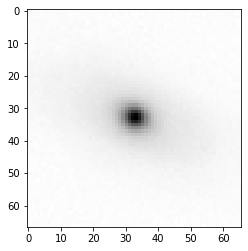

In [ ]:
imshow(im, cmap='gray_r')

So, the point here is that our data has a very specific and specialized structure. You **do not** want your friends who are going to use your dataset to have to worry about it. They don't need to know about astropy tables or HDF5 files.

Before moving own to the next section, let's quickly build a small utility function that will automatize accessing postage stamps from the HDF file:

In [36]:
def stack_bands(cutout, target_size=64):
  import numpy as np

  filters = ['HSC-G', 'HSC-R', 'HSC-I', 'HSC-Z', 'HSC-Y']

  # Retrieve the cutouts in all the bands
  im = [cutout[f]['HDU0']['DATA'][:] for f in filters]

  # Stack all bands in one array
  im_size = min([min(i.shape) for i in im])
  im = np.stack([i[:im_size, :im_size] for i in im], axis=-1).astype('float32')

  # Resize image to target size
  centh = im.shape[0]/2
  centw = im.shape[1]/2
  lh, rh = int(centh-target_size/2), int(centh+target_size/2)
  lw, rw = int(centw-target_size/2), int(centw+target_size/2)
  cropped = im[lh:rh, lw:rw, :]
  assert cropped.shape[0]==target_size and cropped.shape[1]==target_size, f"Wrong size! Still {cropped.shape}"
  return cropped

In [38]:
im = stack_bands(cutouts['36411448540288304']) # We feed it an HDF group
im.shape # It return a cutout with all 5 bands

(64, 64, 5)

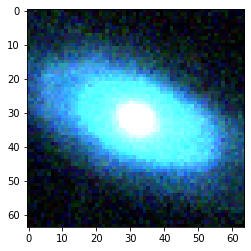

In [39]:
imshow(im[:,:,:3]);

## Let's create a new TensorFlow Dataset for our HSC data

Alright, now that we know how our data is structured, let's see if we can package it as a TFDS dataset.

Below we will follow just the essential steps of the procedure, but you can find more details [here](https://www.tensorflow.org/datasets/add_dataset).

### Step I: Create a new empty dataset file

In [40]:
!tfds new hsc_photoz

2021-12-01 23:57:57.204424: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Dataset generated at /content/hsc_photoz
You can start searching `TODO(hsc_photoz)` to complete the implementation.
Please check https://www.tensorflow.org/datasets/add_dataset for additional details.


You can now find the empty template for defining your dataset in the `hsc_photoz` folder. **Browse the files using the bar on the left**.

Open `hsc_photoz/hsc_photoz.py` and take a look!

We will start by adding a few important imports at the top of the file:

```python
"""hsc_photoz dataset."""
import numpy as np
import tensorflow as tf
...
```

### Step II: Define your dataset metadata

In the `_info()` method, there are two important things to define:
- The features
- The supervised keys 


#### Features

In our dataset, we have a set of images of size 64x64 with 5 bands, and a bunch of associated keys.


```python
    ...,
    features=tfds.features.FeaturesDict({
    'image': tfds.features.Tensor(shape=(64, 64, 5), dtype=tf.float32),
    'attrs': {k: tf.float32 for k in ['specz_redshift', 'a_g', 'a_r', 'a_i', 'a_z', 'a_y']}
        }),
    ...,
```

#### Supervised keys

The main task we want to do with this dataset is to infer redshifts from images, so we can explicitly define the following supervised keys:

```python
    ...,
    supervised_keys=('image', 'attrs/specz_redshift'),
    ...,
```


### Step III: Define how to download your data

One very nice feature of TensorFlow dataset is that you tell it how to download the data from the internet, so that you can easily share the dataset with other people.

This is defined inside the `_split_generators()` method.

You can modify your function to the following:

```python
  def _split_generators(self, dl_manager: tfds.download.DownloadManager):
    """Returns SplitGenerators."""
    # Let TF dataset download our data and put automatically in a temporary folder
    catalog_path = dl_manager.download('https://storage.googleapis.com/ahw2019/hsc_photoz/data/catalog_small.fits')
    cutouts_path = dl_manager.download('https://storage.googleapis.com/ahw2019/hsc_photoz/data/cutouts_small.hdf')
    return [
        tfds.core.SplitGenerator(
            name=tfds.Split.TRAIN,
            # These kwargs will be passed to _generate_examples
            gen_kwargs={'catalog_path': catalog_path,
                        'cutouts_path': cutouts_path},
        ),
    ]
```

### Step IV: Define how to read your data from the native files

And finally we define how the library should open the datafiles, and return examples one by one.

This is done in the `_generate_examples()` method:

```python
  def _generate_examples(self, catalog_path, cutouts_path):
    """Yields examples."""
    from astropy.table import Table
    import h5py

    # Loading the data that was downloaded at the previous step
    catalog = Table.read(catalog_path)
    cutouts = h5py.File(cutouts_path, 'r')

    # Go through the examples
    for object_id in catalog['object_id']:
      row = catalog[catalog['object_id'] == object_id]
      cutout = cutouts[str(object_id)]

      # extract image from cutouts
      im = stack_bands(cutout)
      
      yield object_id, {'image': im, 
                        'attrs':{k: np.asscalar(row[k]) for k in ['specz_redshift', 'a_g', 'a_r', 'a_i', 'a_z', 'a_y']}}
```

and **don't forget to also add our `stack_bands()` function** to your file as well ;-) 

### Step V: Profit!

Make sure you have saved your edited file, and you should now be able to do the following:

In [43]:
import hsc_photoz

In [44]:
dset = tfds.load('hsc_photoz', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/hsc_photoz/1.0.0.incompleteSZIBS1/hsc_photoz-train.tfrecord


  0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset hsc_photoz downloaded and prepared to /root/tensorflow_datasets/hsc_photoz/1.0.0. Subsequent calls will reuse this data.


And tadaa! The code has automatically downloaded our dataset from the cloud and transformed it into an easily ingestible format for TF.

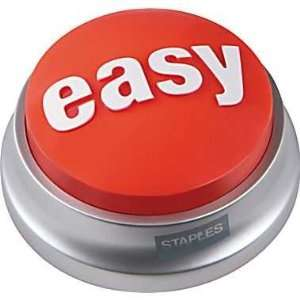

Now that our dataset is prepared we can manipulate it just like MNIST:

In [45]:
dset

<PrefetchDataset shapes: {attrs: {a_g: (), a_i: (), a_r: (), a_y: (), a_z: (), specz_redshift: ()}, image: (64, 64, 5)}, types: {attrs: {a_g: tf.float32, a_i: tf.float32, a_r: tf.float32, a_y: tf.float32, a_z: tf.float32, specz_redshift: tf.float32}, image: tf.float32}>

In [46]:
for example in dset.take(1):
  print(example['attrs']['specz_redshift'])

tf.Tensor(0.78139, shape=(), dtype=float32)


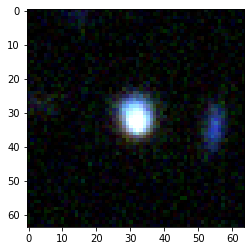

In [47]:
imshow(example['image'][:,:,0:3])


In an actual project, you would add this generated code to your python package,
making it trivial for other people to use.